In [1]:
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

# Check if TensorFlow has access to GPU
if len(physical_devices) > 0:
    print(f"GPUs detected: {len(physical_devices)}")
    # Set memory growth to True for all GPUs
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"Memory growth set to True")
else:
    print("No GPUs detected. Please check your CUDA and cuDNN setup.")

GPUs detected: 8
Memory growth set to True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=10)
plt.rcParams["font.family"] = "serif"

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, BatchNormalization, concatenate, Layer, Lambda, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from scipy.stats import wasserstein_distance
import pandas as pd

In [3]:
#load and normalize the data
data = np.load('rawdata.npz')
substructure_variables = ['w', 'q', 'm', 'r', 'tau1s', 'tau2s']
data_streams = ['_true', '_true_alt', '_reco', '_reco_alt']
n_variables = len(substructure_variables)


normalize = True
    
for var_name in data.files:
    globals()[var_name] = data[var_name][:150000]
    
if normalize:
    for var_name in substructure_variables:
        mu = np.mean(globals()[var_name+data_streams[0]])
        sig = np.std(globals()[var_name + data_streams[0]])
        for stream in data_streams:
            globals()[var_name+stream] = (globals()[var_name+stream] - mu)/sig

In [4]:
N = len(m_true)

xvals_truth = np.array([np.concatenate([globals()[f"{var_name}_true_alt"], globals()[f"{var_name}_true"]]) for var_name in substructure_variables]).T
xvals_reco = np.array([np.concatenate([globals()[f"{var_name}_reco_alt"], globals()[f"{var_name}_reco"]]) for var_name in substructure_variables]).T
                    
yvals = np.concatenate([np.zeros(N, dtype=np.float32),np.ones(N, dtype=np.float32)])

X_train_truth, X_test_truth, X_train_reco, X_test_reco, Y_train, Y_test = train_test_split(
    xvals_truth, xvals_reco, yvals)


In [5]:
tf.keras.utils.get_custom_objects().clear()

@tf.keras.utils.register_keras_serializable(package="Custom", name="weighted_binary_crossentropy")
def weighted_binary_crossentropy(target, output, weights):
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    output = tf.convert_to_tensor(output, dtype=tf.float32)
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)
    
    epsilon_ = tf.keras.backend.epsilon()
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)
    
    weights_1 = tf.reduce_sum(target * weights)
    weights_0 = tf.reduce_sum((1 - target) * weights)
    
    bce_1 = target * tf.math.log(output + epsilon_) * weights / weights_1
    bce_0 = (1 - target) * tf.math.log(1 - output + epsilon_) * weights / weights_0
    weighted_bce = -tf.reduce_mean(bce_1 + bce_0) * tf.cast(tf.shape(target)[0], dtype=tf.float32)
    return weighted_bce
    
@tf.keras.utils.register_keras_serializable(package="Custom", name="weighted_binary_crossentropy_GAN")
def weighted_binary_crossentropy_GAN(target, output, weights):
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    output = tf.convert_to_tensor(output, dtype=tf.float32)
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)

    epsilon_ = tf.keras.backend.epsilon()
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)
    
    weights_sum = tf.reduce_sum((1 - target) * weights)
    bce = weights * (1 - target) * tf.math.log(1 - output + epsilon_) / weights_sum
    weighted_bce = 2 * tf.reduce_mean(bce) * tf.cast(tf.shape(target)[0], dtype=tf.float32)
    return weighted_bce


In [6]:
# Model configuration
gen_model_width = 100
gen_model_depth = 5
disc_model_width = 50
disc_model_depth = 3
dropout_rate = 0.0

# Generator model
def build_generator(input_shape):
    gen_input = Input(shape=(input_shape,))
    x = gen_input
    
    # Initialize kernel
    kernel_init = RandomNormal(mean=0.0, stddev=0.2)
    
    # Hidden layers
    for _ in range(gen_model_depth):
        x = Dense(gen_model_width, activation='relu', use_bias=False, kernel_initializer=kernel_init if _ == 0 else None)(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Output layer
    x = Dense(1, activation='softplus', use_bias=False)(x)
    outputs = Lambda(lambda x: x / K.log(2.0))(x)
    return Model(inputs=gen_input, outputs=outputs)

# Discriminator model
def build_discriminator(input_shape):
    disc_inputs = Input(shape=(input_shape,))
    
    # Hidden layers
    x = disc_inputs
    for _ in range(disc_model_depth):
        x = Dense(disc_model_width, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.2) if _ == 0 else None)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=disc_inputs, outputs=outputs)

# Create the models
model_generator = build_generator(xvals_truth.shape[1])
model_discriminator = build_discriminator(xvals_reco.shape[1])

In [7]:
optimizer_disc = Adam(learning_rate=0.0001, beta_1 = 0.3)
optimizer_gen = Adam(learning_rate=0.0002, beta_1 = 0.5)

@tf.function
def train_step_discriminator(X_detector_batch, Y_batch, W_batch):
    model_discriminator.trainable = True
    model_generator.trainable = False
    with tf.GradientTape() as tape:
        predictions = model_discriminator(X_detector_batch, training=True)
        loss = weighted_binary_crossentropy(Y_batch, predictions, W_batch)
    grads = tape.gradient(loss, model_discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(grads, model_discriminator.trainable_variables))
    return loss

@tf.function
def train_step_gan(X_particle_batch, X_detector_batch, Y_batch):
    model_discriminator.trainable = False
    model_generator.trainable = True
    with tf.GradientTape() as tape:
        W_batch = model_generator(X_particle_batch, training=True) 
        W_batch = tf.where(Y_batch == 1, 1.0, tf.squeeze(W_batch))
        discriminator_output = model_discriminator(X_detector_batch, training=False)  
        loss = weighted_binary_crossentropy_GAN(Y_batch, discriminator_output, W_batch)
    grads = tape.gradient(loss, model_generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads, model_generator.trainable_variables))
    return loss
    
disc_loss_avg = []
gen_loss_avg = []

In [8]:
checkpoint_dir = '.model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Paths for the checkpoint files
checkpoint_path_gen = os.path.join(checkpoint_dir, 'generator_epoch-{epoch:04d}.weights.h5')
checkpoint_path_disc = os.path.join(checkpoint_dir, 'discriminator_epoch-{epoch:04d}.weights.h5')

In [9]:
n_epochs = 10
batch_size = X_train_reco.shape[0]//100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reco, X_train_truth, Y_train)).batch(batch_size)

m = 2  # Number of generator updates
n = 1  # Number of discriminator updates

performance_metric = np.empty((n_epochs, n_variables))
data_set_1 = X_test_truth[Y_test == 1]
data_set_2 = X_test_truth[Y_test == 0]
baseline = np.array([wasserstein_distance(data_set_1[:, i], data_set_2[:, i]) for i in range(n_variables)])

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    discriminator_losses = []
    generator_losses = []

    for X_detector_batch, X_particle_batch, Y_batch in train_dataset:
        # Discriminator update loop
        for _ in range(n):
            model_generator.trainable = False
            W_batch = model_generator.predict(X_particle_batch, verbose=0)
            W_batch = tf.where(Y_batch == 1, 1.0, tf.squeeze(W_batch))
            d_loss = train_step_discriminator(X_detector_batch, Y_batch, W_batch)
            discriminator_losses.append(d_loss.numpy())

        # Generator update loop
        for _ in range(m):
            alt_indices = tf.where(Y_batch == 0)
            X_particle_alt = tf.gather_nd(X_particle_batch, alt_indices)
            X_detector_alt = tf.gather_nd(X_detector_batch, alt_indices)
            Y_alt = tf.gather_nd(Y_batch, alt_indices)
            g_loss = train_step_gan(X_particle_alt, X_detector_alt, Y_alt)
            generator_losses.append(g_loss.numpy())

    # Log and printing specs about the model
    avg_d_loss = np.mean(discriminator_losses[-n*len(train_dataset):])
    avg_g_loss = np.mean(generator_losses[-m*len(train_dataset):])
    gen_loss_avg.append(avg_g_loss)
    disc_loss_avg.append(avg_d_loss)   
    print(f"Epoch {epoch+1} completed. Discriminator Loss: {avg_d_loss}, Generator Loss: {avg_g_loss}")
    if (epoch + 1) % 10 == 0:
        gen_checkpoint_path = checkpoint_path_gen.format(epoch=epoch + 1)
        disc_checkpoint_path = checkpoint_path_disc.format(epoch=epoch + 1)
        model_generator.save_weights(gen_checkpoint_path)
        model_discriminator.save_weights(disc_checkpoint_path)
        print(f'Saved generator and discriminator at epoch {epoch + 1}')
    weights = model_generator.predict(X_test_truth[Y_test == 0], verbose=0).flatten()
    performance_metric[epoch, :] = [wasserstein_distance(data_set_1[:, i], data_set_2[:, i], 
                                                          u_weights=None, v_weights=weights) 
                                    for i in range(n_variables)]

Epoch 1/10


I0000 00:00:1712347466.198420  184204 service.cc:145] XLA service 0x7fcb10007eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712347466.198444  184204 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712347466.198447  184204 service.cc:153]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712347466.198449  184204 service.cc:153]   StreamExecutor device (2): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712347466.198451  184204 service.cc:153]   StreamExecutor device (3): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712347466.198454  184204 service.cc:153]   StreamExecutor device (4): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712347466.198456  184204 service.cc:153]   StreamExecutor device (5): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1712347466.198458  184204 service.cc:153]   StreamE

Epoch 1 completed. Discriminator Loss: 1.386897087097168, Generator Loss: -1.382143259048462
Epoch 2/10
Epoch 2 completed. Discriminator Loss: 1.386415958404541, Generator Loss: -1.3861441612243652
Epoch 3/10
Epoch 3 completed. Discriminator Loss: 1.3863613605499268, Generator Loss: -1.386287808418274
Epoch 4/10
Epoch 4 completed. Discriminator Loss: 1.3863404989242554, Generator Loss: -1.3863325119018555
Epoch 5/10
Epoch 5 completed. Discriminator Loss: 1.3863290548324585, Generator Loss: -1.3863060474395752
Epoch 6/10
Epoch 6 completed. Discriminator Loss: 1.386322021484375, Generator Loss: -1.386279582977295
Epoch 7/10
Epoch 7 completed. Discriminator Loss: 1.3863171339035034, Generator Loss: -1.3862684965133667
Epoch 8/10
Epoch 8 completed. Discriminator Loss: 1.3863134384155273, Generator Loss: -1.3862649202346802
Epoch 9/10
Epoch 9 completed. Discriminator Loss: 1.3863110542297363, Generator Loss: -1.3862653970718384
Epoch 10/10
Epoch 10 completed. Discriminator Loss: 1.386309504

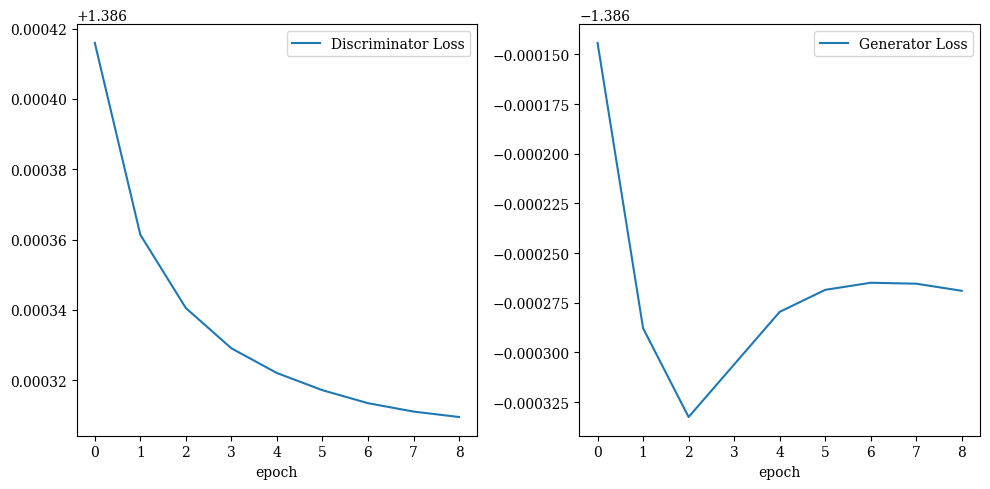

In [10]:
plt.figure(figsize=(10, 5))

# Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(disc_loss_avg[1:], label='Discriminator Loss')
plt.xlabel('epoch')
plt.legend()

# Generator Loss
plt.subplot(1, 2, 2)
plt.plot(gen_loss_avg[1:], label='Generator Loss')
plt.xlabel('epoch')
plt.legend()

plt.tight_layout()
plt.show()

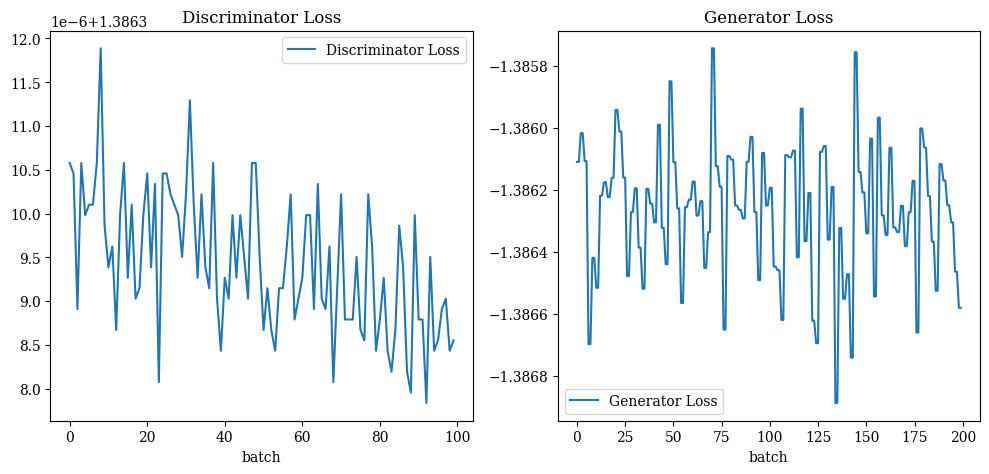

In [11]:
plt.figure(figsize=(10, 5))
#plt.title("Losses by batch")

# Discriminator Loss
plt.subplot(1, 2, 1) 
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('batch')
plt.legend()

# Generator Loss
plt.subplot(1, 2, 2) 
plt.plot(generator_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('batch')
plt.legend()

plt.tight_layout()
plt.show()

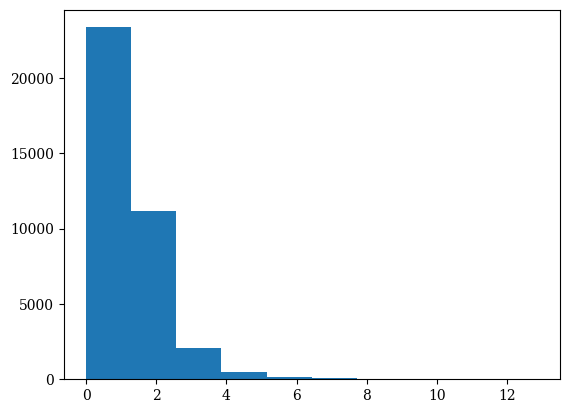

In [12]:
plt.hist(weights)
plt.show()

In [13]:
def moment(x, n, w=None):
    return np.average(x**n, weights = w)

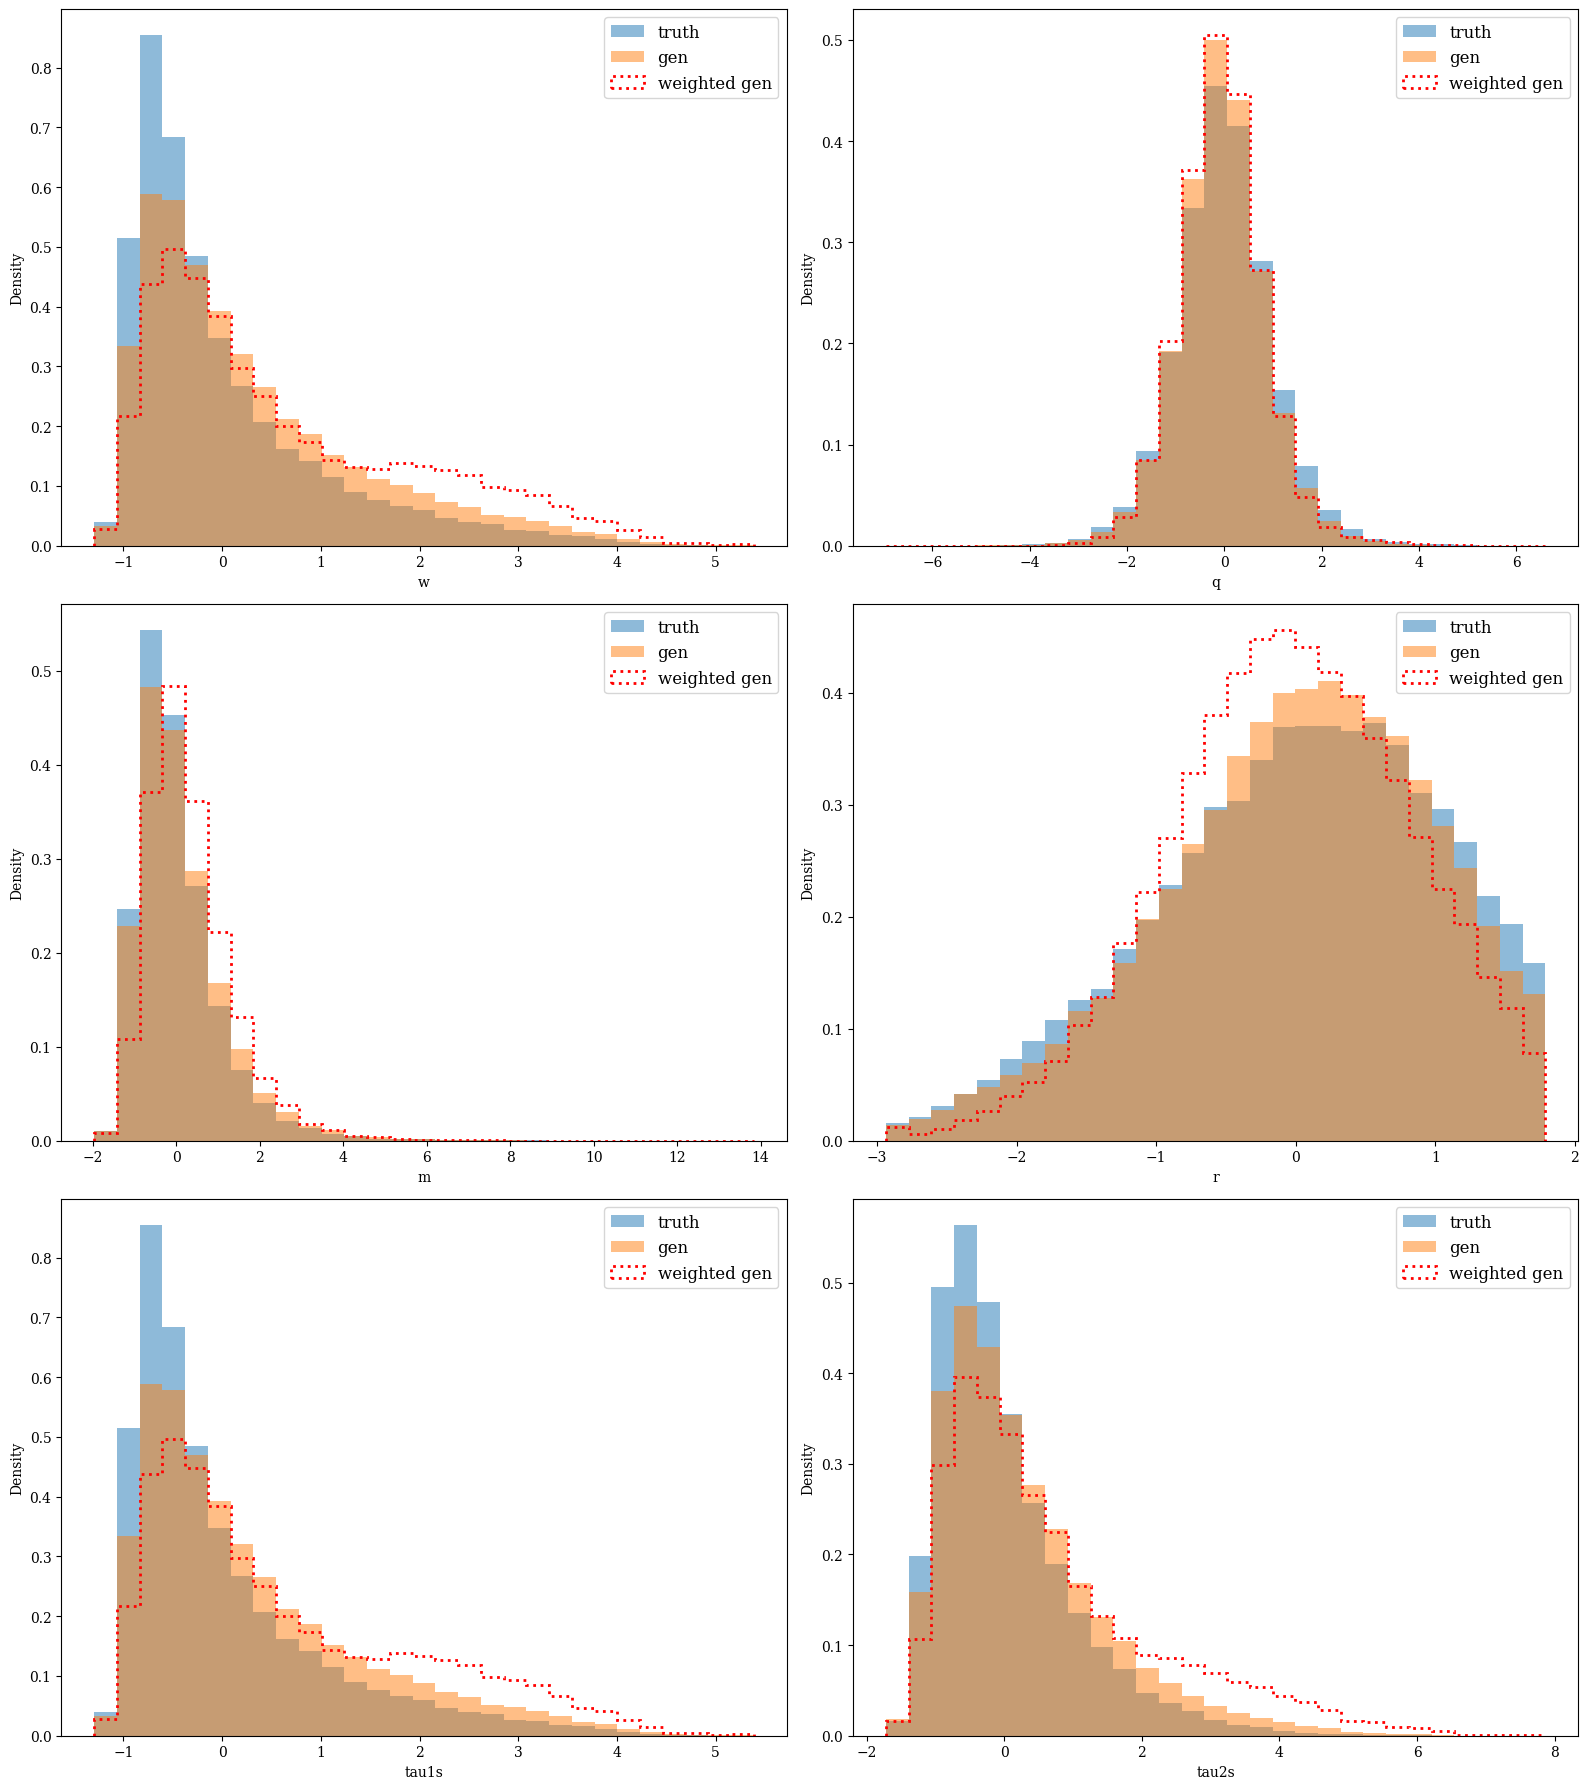

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(16, 18))
axs = axs.flatten()
nbins = 30
density = True

for i, var_name in enumerate(substructure_variables):
    X = X_test_truth[:, i]*np.std(globals()[var_name + '_true']) + np.mean(globals()[var_name + '_true'])
    bins = np.linspace(X.min(), X.max(), nbins)
    
    axs[i].hist(X[Y_test == 1], bins=bins, alpha=0.5, label="truth", density=density, zorder=-1)
    axs[i].hist(X[Y_test == 0], bins=bins, alpha=0.5, label="gen", density=density, zorder=0)
    axs[i].hist(X[Y_test == 0], bins=bins, weights=weights,
                histtype="step", color="red", ls=":", lw=2, label="weighted gen", density=density, zorder=1)
    
    axs[i].legend(fontsize=12)
    axs[i].set_ylabel("Density")
    axs[i].set_xlabel(var_name)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [15]:
for n in range(1,3):
    print("Moment", n)
    for i, var_name in enumerate(substructure_variables):
        X = X_test_truth[:, i]*np.std(globals()[var_name + '_true']) + np.mean(globals()[var_name + '_true'])
        print(f"\t{var_name} truth: {moment(X[Y_test == 1], n) :}")
        print(f"\t{var_name} gen: {moment(X[Y_test == 0], n):}")
        print(f"\t{var_name} unfolded: {moment(X[Y_test == 0], n, weights):}")

Moment 1
	w truth: 0.008558469146393074
	w gen: 0.2967463657485504
	w unfolded: 0.6448105036261279
	q truth: 0.0015842281033760129
	q gen: -0.05016524977899894
	q unfolded: -0.048283977378992635
	m truth: 0.004246064014966137
	m gen: 0.12188697099192264
	m unfolded: 0.3415875792549891
	r truth: 0.0021489736027960013
	r gen: 0.002272328961942479
	r unfolded: -0.0538535556052998
	tau1s truth: 0.008558469146393074
	tau1s gen: 0.2967463657485504
	tau1s unfolded: 0.6448105036261279
	tau2s truth: 0.00629518118839361
	tau2s gen: 0.27726138525862865
	tau2s unfolded: 0.716048675049125
Moment 2
	w truth: 1.011616563896088
	w gen: 1.3706742176624287
	w unfolded: 2.201720922031073
	q truth: 0.9987142673748088
	q gen: 0.8063688204689818
	q unfolded: 0.7582468154815958
	m truth: 1.0165003443327867
	m gen: 1.2016260575981599
	m unfolded: 1.2054423484373957
	r truth: 1.0037229502361515
	r gen: 0.9080747304778468
	r unfolded: 0.7418370302530752
	tau1s truth: 1.011616563896088
	tau1s gen: 1.370674217662

In [16]:
pd.set_option('display.float_format', '{:.3f}'.format)
baseline_df = pd.DataFrame([baseline], columns=substructure_variables, index=['Baseline'])
performance_df = pd.DataFrame(performance_metric, columns=substructure_variables, index=pd.Index(range(1, n_epochs+1), name='Epoch'))
results_df = pd.concat([baseline_df, performance_df])
max_threshold = 1e3
results_df = results_df.map(lambda x: np.nan if abs(x) > max_threshold else x)


#selected_epochs = ['Baseline'] + list(range(1, n_epochs+1, 10))
#display_df = results_df.loc[selected_epochs]

#print(display_df)


In [17]:
results_df

,w,q,m,r,tau1s,tau2s
Baseline,0.288,0.085,0.118,0.049,0.288,0.271
1,0.485,0.105,0.247,0.085,0.485,0.491
2,0.572,0.090,0.306,0.125,0.572,0.616
3,0.621,0.100,0.331,0.145,0.621,0.688
4,0.658,0.108,0.355,0.157,0.658,0.733
5,0.611,0.102,0.324,0.147,0.611,0.682
6,0.622,0.105,0.331,0.150,0.622,0.694
7,0.656,0.109,0.353,0.156,0.656,0.729
8,0.640,0.106,0.342,0.154,0.640,0.714
9,0.619,0.105,0.329,0.149,0.619,0.692
